In [ ]:
# default_exp nbutils

# Tracking

> Simple Store, Pull, and Visualize data in nosql format

In [ ]:
#export
from functools import reduce
import operator
import shelve
import pandas as pd
import matplotlib.pyplot as plt

from functools import partial
from fastcore.test import test_fail

In [ ]:
# common structure

test_dict = {'ex':1,
        'resnet18': {'epoch1': {'loss': 0.011, 'accuracy': 0.11},
                     'epoch2': {'loss': 0.012, 'accuracy': 0.12},
                     'epoch3': {'loss': 0.013, 'accuracy': 0.13}},
        'resnet34': {'notes':f'tried cleaning up images via edge detection',
                     'epoch1': {'loss': 0.021, 'accuracy': 0.21, 'error': 0.79, 'batch1':{'loss':.23}, 'batch2':{'loss':.23}},
                     'epoch2': {'loss': 0.022, 'accuracy': 0.22, 'error': 0.78, 'batch1':{'loss':.23}, 'batch2':{'loss':.33}},
                     'epoch3': {'loss': 0.023, 'accuracy': 0.23, 'error': 0.77, 'batch1':{'loss':.23}, 'batch2':{'loss':.43}}},
         'resnet50':{'epoch1': {'loss': 0.031, 'accuracy': 0.31, 'error': 0.69},
                     'epoch2': {'loss': 0.032, 'accuracy': 0.32, 'error': 0.68},
                     'epoch3': {'loss': 0.033, 'accuracy': 0.33, 'error': 0.67},
                     'epoch4': {'loss': 0.033, 'accuracy': 0.33, 'error': 0.67}}}

# Dict Foundations

In [ ]:
#export

#https://stackoverflow.com/questions/14692690/access-nested-dictionary-items-via-a-list-of-keys
def get_by_path(dict_obj, keys):
    """Access a nested object in root by item sequence."""
    return reduce(operator.getitem, keys, dict_obj)

In [ ]:
assert get_by_path(test_dict,['ex']) == 1
assert get_by_path(test_dict,['resnet18','epoch1','loss']) == 0.011

In [ ]:
def set_by_path(dict_obj, keys, value):
    """Set a value in a nested object in root by item sequence."""
    get_by_path(dict_obj, keys[:-1])[keys[-1]] = value

In [ ]:
set_by_path(test_dict,['ex'],2)
assert get_by_path(test_dict,['ex']) == 2

set_by_path(test_dict,['resnet18','epoch1','loss'],0.025)
assert get_by_path(test_dict,['resnet18','epoch1','loss']) == 0.025

In [ ]:
def del_by_path(dict_obj, keys):
    """Delete a key-value in a nested object in root by item sequence."""
    del get_by_path(dict_obj, keys[:-1])[keys[-1]]

In [ ]:
del_by_path(test_dict,['ex'])
f = partial(get_by_path,test_dict,['ex'])
test_fail(f)

# Dict Query

Need to change this to be able to dictate a level to look for a stat in.  For example look for loss in level 3 would grab epoch loss, where as level 4 may grab batch loss.  Maybe recursion

In [ ]:
#export
def get_epoch_stat(dict_obj,key):
    tmp = []
    for k_exp, v_exp in dict_obj.items():
        for k_epoch, v_epoch in dict_obj[k_exp].items():
            if not k_epoch.startswith('epoch'): continue
            for k_stats, v_stats in dict_obj[k_exp][k_epoch].items():
                if k_stats==key:
                    tmp.append(pd.DataFrame({'exp_key':[k_exp],'epoch_key':[k_epoch],'stat_key':[k_stats],'stat_value':[v_stats]}))
    return pd.concat(tmp)

In [ ]:
epoch_stat = get_epoch_stat(test_dict,'loss')
epoch_stat

,exp_key,epoch_key,stat_key,stat_value
0,resnet18,epoch1,loss,0.025
0,resnet18,epoch2,loss,0.012
0,resnet18,epoch3,loss,0.013
0,resnet34,epoch1,loss,0.021
0,resnet34,epoch2,loss,0.022
0,resnet34,epoch3,loss,0.023
0,resnet50,epoch1,loss,0.031
0,resnet50,epoch2,loss,0.032
0,resnet50,epoch3,loss,0.033
0,resnet50,epoch4,loss,0.033


In [ ]:
#export
def plot_epoch_stat(dict_obj,key,most_recent_n=3,figsize=(12,6)):
    epoch_stat = get_epoch_stat(dict_obj,key)
    fig,ax = plt.subplots(figsize=figsize)
    exps = epoch_stat.iloc[:,0].unique()

    for i,exp in enumerate(exps):
        if i < len(exps)-most_recent_n: continue
        exp_df = epoch_stat.loc[epoch_stat.exp_key==exp,:]
        ax.plot(range(len(exp_df)),exp_df.stat_value,label=exp)
        ax.legend();ax.set_title(f'epoch {key}')
    plt.show()
  

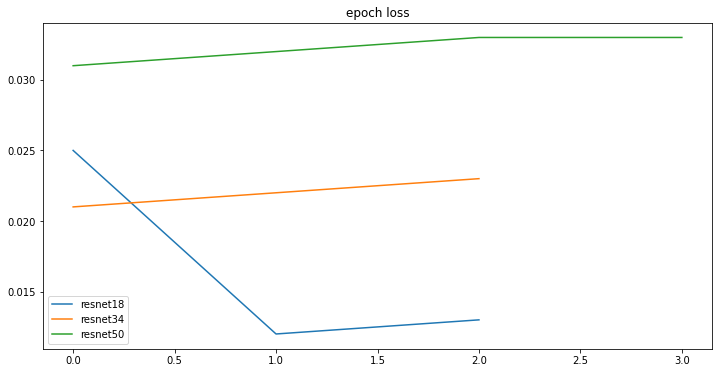

In [ ]:
plot_epoch_stat(test_dict,'loss')

In [ ]:
#export
def get_batch_stat(dict_obj,key):
    tmp = []
    for k_exp, v_exp in dict_obj.items():
        for k_epoch, v_epoch in dict_obj[k_exp].items():
            if not k_epoch.startswith('epoch'): continue
            for k_batch, v_batch in dict_obj[k_exp][k_epoch].items():
                if not k_batch.startswith('batch'): continue
                for k_stats, v_stats in dict_obj[k_exp][k_epoch][k_batch].items():
                  if k_stats==key:
                      tmp.append(pd.DataFrame({'exp_key':[k_exp],'epoch_key':[k_epoch],'batch_key':[k_batch],'stat_key':[k_stats],'stat_value':[v_stats]}))
    return pd.concat(tmp)

In [ ]:
batch_stat = get_batch_stat(test_dict,'loss')
batch_stat

,exp_key,epoch_key,batch_key,stat_key,stat_value
0,resnet34,epoch1,batch1,loss,0.23
0,resnet34,epoch1,batch2,loss,0.23
0,resnet34,epoch2,batch1,loss,0.23
0,resnet34,epoch2,batch2,loss,0.33
0,resnet34,epoch3,batch1,loss,0.23
0,resnet34,epoch3,batch2,loss,0.43


In [ ]:
#export
def plot_batch_stat(dict_obj,key,most_recent_n=3,figsize=(12,6)):
    epoch_stat = get_batch_stat(dict_obj,key)
    fig,ax = plt.subplots(figsize=figsize)
    exps = epoch_stat.iloc[:,0].unique()

    for i,exp in enumerate(exps):
        if i < len(exps)-most_recent_n: continue
        exp_df = epoch_stat.loc[epoch_stat.exp_key==exp,:]
        ax.plot(range(len(exp_df)),exp_df.stat_value,label=exp)
        ax.legend();ax.set_title(f'batch {key}')
    plt.show()

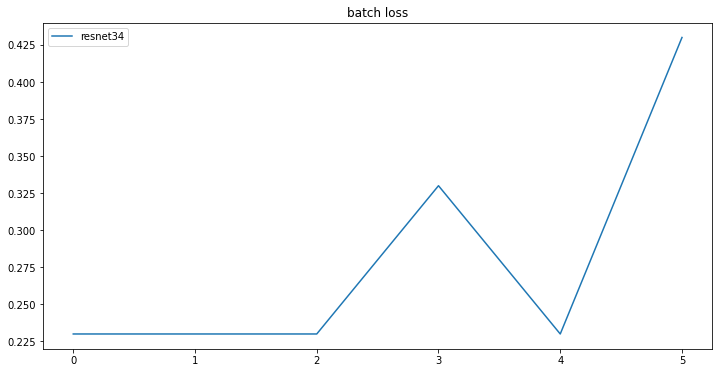

In [ ]:
plot_batch_stat(test_dict,'loss')

# Shelve

Having trouble updating subdicts.  Maybe just write to json and parse.

In [ ]:
# def get_stat(fname,keys,level=3):
#     with shelve.open(fname) as d:
#         out = get_by_path(d,keys)
#     return out

# def write_stat(fname, keys, value):
#     with shelve.open(fname) as d:
#         get_by_path(d, keys[:-1])[keys[-1]] = value
#     #return out
    
# get_stat('test',['1']),get_stat('test',['1','a'])